<a href="https://colab.research.google.com/github/ccarpenterg/introNLP/blob/master/02a_NLP_and_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing and Neural Networks

In [1]:
!pip install -q tensorflow-datasets==1.3.2

     |████████████████████████████████| 3.0MB 8.3MB/s 


In [2]:
# load Tensorflow 2
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow import keras

import tensorflow_datasets as tfds
import numpy as np

print("Tensorflow version:", tf.__version__)
print("Tensorflow datasets version:", tfds.__version__)

TensorFlow 2.x selected.
Tensorflow version: 2.1.0
Tensorflow datasets version: 1.3.2


## Sentiment Analysis of IMDB Movie Reviews

In [3]:
train_validation_split = tfds.Split.TRAIN.subsplit([8, 2])

(train_validation_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (train_validation_split, tfds.Split.TEST),
    as_supervised=True,
    with_info=True
)

train_data, validation_data = train_validation_data

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


In [4]:
print(info.description)

Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.


In [5]:
print('Train examples:', info.splits['train'].num_examples)
print('Test examples:', info.splits['test'].num_examples)

Train examples: 25000
Test examples: 25000


In [6]:
encoder = info.features['text'].encoder

print('Vocabulary size: {}'.format(encoder.vocab_size))

sample_string = 'A great movie!'

encoded_string = encoder.encode(sample_string)

print(encoded_string)

Vocabulary size: 8185
[133, 122, 65, 7962]


In [7]:
for ts in encoded_string:
    print('{} ---> {}'.format(ts, encoder.decode([ts])))

133 ---> A 
122 ---> great 
65 ---> movie
7962 ---> !


In [8]:
print(encoder.decode(encoded_string))

A great movie!


In [9]:
for train_example, train_label in train_data.take(1):
    print(train_example[:7].numpy())
    print(train_label.numpy())

[ 249    4  277  309  560    6 6639]
1


In [10]:
print(encoder.decode(train_example))

As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a cliché, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by a journalist rather than a novelist. It's not really Dickens 

## Preprocessing the Data with Padding

In [0]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, tf.compat.v1.data.get_output_shapes(train_data))
)

validation_batches = (
    validation_data
    .padded_batch(32, tf.compat.v1.data.get_output_shapes(validation_data))
)

test_batches = (
    test_data
    .padded_batch(32, tf.compat.v1.data.get_output_shapes(train_data))
)

In [12]:
for batch_example, labels in train_batches.take(2):
    print("Batch shape:", batch_example.shape)
    print("Label shape:", labels.shape)

Batch shape: (32, 712)
Label shape: (32,)
Batch shape: (32, 1288)
Label shape: (32,)


## Sequence Processing with a Neural Network

* Embedding layer
* Global Average Pooling layer
* Dense hidden layer
* Dense classifier

In [15]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.001))
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


Regardless of the sequence length, the NN converts it to a vector of embedding's dimension. This is done through the Global Average Pooling layer.

### Counting Parameters

**Embedding layer:** 8185 (vocabulary length) * 16 (embedding dimension) = 130,960 parameters

**FC layer:** 16 x 16 weights + 16 biases = 272 parameters

**Dense classifier:** 1 * 16 weights + 1 bias = 17 parameters


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
training_results = model.fit(train_batches,
                             epochs=15,
                             validation_data=validation_batches,
                             validation_steps=30)

Epoch 1/15
625/625 [==============================] - 10s 16ms/step - loss: 0.6957 - accuracy: 0.5632 - val_loss: 0.6889 - val_accuracy: 0.5167
Epoch 2/15
625/625 [==============================] - 7s 10ms/step - loss: 0.6247 - accuracy: 0.7210 - val_loss: 0.5426 - val_accuracy: 0.8083
Epoch 3/15
625/625 [==============================] - 6s 10ms/step - loss: 0.4827 - accuracy: 0.8584 - val_loss: 0.4561 - val_accuracy: 0.8687
Epoch 4/15
625/625 [==============================] - 7s 11ms/step - loss: 0.4237 - accuracy: 0.8863 - val_loss: 0.4275 - val_accuracy: 0.8708
Epoch 5/15
625/625 [==============================] - 6s 10ms/step - loss: 0.3927 - accuracy: 0.8995 - val_loss: 0.4105 - val_accuracy: 0.8813
Epoch 6/15
625/625 [==============================] - 6s 10ms/step - loss: 0.3734 - accuracy: 0.9064 - val_loss: 0.4195 - val_accuracy: 0.8719
Epoch 7/15
625/625 [==============================] - 6s 10ms/step - loss: 0.3583 - accuracy: 0.9118 - val_loss: 0.3947 - val_accuracy: 0.887

In [18]:
loss, accuracy = model.evaluate(test_batches)

    782/Unknown - 5s 7ms/step - loss: 0.4121 - accuracy: 0.8789

## Overfitting

In [19]:
training_dict = training_results.history
training_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

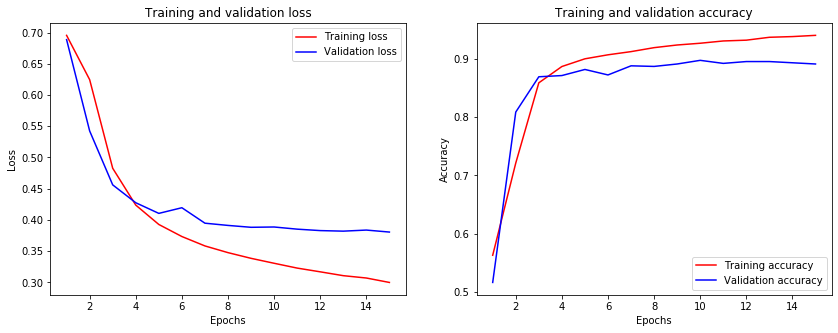

In [20]:
import matplotlib.pyplot as plt

acc = training_dict['accuracy']
val_acc = training_dict['val_accuracy']
loss = training_dict['loss']
val_loss = training_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Exploring our Word Embeddings

In [0]:
word_embeddings = model.layers[0]

In [22]:
encoded_string = encoder.encode("Great movie! But not as good as The Matrix")

for ts in encoded_string:
    print('{} ---> {}'.format(ts, encoder.decode([ts])))

1976 ---> Great 
65 ---> movie
90 ---> ! 
128 ---> But 
33 ---> not 
20 ---> as 
74 ---> good 
20 ---> as 
19 ---> The 
1495 ---> Mat
7190 ---> rix


In [23]:
word_embeddings(tf.constant(encoded_string))

<tf.Tensor: shape=(11, 16), dtype=float32, numpy=
array([[ 2.0731351 , -2.1139145 , -2.180684  , -2.1460388 , -2.1209397 ,
        -2.130702  ,  2.1875317 , -2.1459446 , -2.148039  ,  2.1069722 ,
         2.120585  ,  2.1151714 ,  2.127604  ,  2.053482  , -2.140315  ,
         2.1550531 ],
       [-0.25596917,  0.40182275,  0.35381427,  0.42762247,  0.34005475,
         0.31712258, -0.3745746 ,  0.3173669 ,  0.32866365, -0.31091097,
        -0.47091895, -0.31866053, -0.36541218, -0.31271908,  0.29460517,
        -0.28636786],
       [ 0.3049061 , -0.3059851 , -0.27551225, -0.34516537, -0.36202347,
        -0.27334708,  0.359693  , -0.31684324, -0.3341183 ,  0.30769145,
         0.24627277,  0.33905813,  0.31481278,  0.2996428 , -0.33668712,
         0.37835664],
       [ 0.03756322, -0.11449406, -0.08380247, -0.0713172 , -0.02906256,
         0.02200111,  0.06665381, -0.07858638, -0.0084738 ,  0.07134329,
         0.00961717,  0.08563627,  0.03006605,  0.06143075, -0.0396352 ,
        